# Assignment 05: RESNET-18

***Due Date: 10Sep2024***

* Train on Human Action Recognition (%40) https://www.kaggle.com/datasets/shashankrapolu/human-action-recognition-dataset/data

    1. Evaluation on test set human-action-recognition
    2. 15 classes, 218 MB, 12600 images, train/test split availabe
    3. Use Newton
    4. ResNet 18

* Report and code zip (10%)
    1. Errors and obstacles faced running the model
    2. Must have conda requirement.txt, cli commands to generate the evaluation results above (random checks will be performed to verify)
    3. Training Log

* Live Demo Video (20%)
    1. The video should comprise of visual outputs (e.g. tect cat overlay on the image being classified that has a cat in it.)

* Insights on speed and memory efficiency (30%)
    1. Bonus 100 points: If you can apply what we have discussed on model efficiency (distillation, SMoE, "caching") with demonstrated >1.5x speed up before and after


### Explanation of the Human Action Recognition Dataset

***Introduction:***
We have a structured dataset split into train and test containing 15 classes each. The classes are calling, clapping, cycling, dancing, drinking, eating, fighting, hugging, laughing, listening to music, running, sitting, sleeping, texting, and using a laptop. There are a total of 12600 images with a split ratio of 85-15%, into train and test respectively.

***Purpose:***
The purpose of this dataset is to identify a human action, by the computer. Unfortunately, as there are myriad actions that can be performed by humans, it is not possible to include all. Therefore only 15 types of routine actions have been provided.

***Problem Statement:***
Your task is to come up with a model that takes an image as an input and predicts among the 15 mentioned classes.

Sources:

https://github.com/AarohiSingla/Image-Classification-Using-Pytorch


https://www.youtube.com/watch?v=cJpwQJp9flU



In [ ]:
# =======================================================#
# 1. Import basic Modules and Functions and set variables
# =======================================================#

import torch
import torch.nn as nn # All the Neural network models, loss functions
import torch.optim as optim # Optimization algorithms
import torch.nn.functional as F # All functions without parameters
from torch.utils.data import DataLoader # Easier dataset management such as minibatches
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import os


# Import some packages for logging training and showing progress
import datetime
import logging
import tqdm


# Set up some basic logging to record traces of training
logging.basicConfig(
        level=logging.INFO,
        format="%(asctime)s %(levelname)s %(message)s",
        datefmt="%Y-%m-%d %H:%M:%S",
        filename="Assignment_05.txt" # Save log to a file
    )




# Hyperparameters

learning_rate = 0.0001
num_epochs = 60
momentum = 0.9
epoch_counter = 0
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')




In [ ]:
# =======================================================#
# 2. Define Data Transforms for Data Augmentation
# =======================================================#

data_transforms = {

    'train': transforms.Compose([
        transforms.RandomResizedCrop(224), # Randomly resize and crop all input images to 224x244
        transforms.RandomHorizontalFlip(), # Horizontally flip images randomly
        transforms.ToTensor(), # Transforms images to tensors. This is mandatory
        transforms.Normalize([0.485,0.456,0.406 ], [0.229,0.224,0.225]) # Normalize the data so that it is all on the same scale. First Array is the RGB channels. Second array are the standardization of values
    ]),
    'test': transforms.Compose([
        transforms.RandomResizedCrop(224), # Randomly resize and crop all input images to 224x244
        transforms.RandomHorizontalFlip(), # Horizontally flip images randomly
        transforms.ToTensor(), # Transforms images to tensors. This is mandatory
        transforms.Normalize([0.485,0.456,0.406 ], [0.229,0.224,0.225]) # Normalize the data so that it is all on the same scale. First Array is the RGB channels. Second array are the standardization of values
    ])
}

In [ ]:
# =======================================================#
# 2. Define Data Directory
# =======================================================#
data_dir = 'data'

# Create Dataloaders: Dataloaders are responsible for loading the data
image_data = {x: datasets.ImageFolder(os.path.join(data_dir,x), data_transforms[x]) for x in ['train','test']}

# Image Datasets
dataloaders = {x: DataLoader(image_data[x], batch_size=4, shuffle=True, num_workers=4) for x in ['train','test'] } # num_workers is equal to the number of parallel processes to process the data
dataset_sizes = {x: len(image_data[x]) for x in ['train','test']}
print(dataset_sizes)

class_names = image_data['train'].classes

class_names

In [ ]:
# Load Pretrained ResNet-18 Model to train on

model = models.resnet18(pretrained=True)

# Freeze all layers of the pretrained model except the final classification layer
# The reason we freeze all the layers except the last one is to preserve the pretrained weights to save time and increase accuracy since the masters have already done the work
for name, param in model.named_parameters():
    if 'fc' in name: #Unfreeze finale classification layer
        param.requires_grad = True
    else:
        param.requires_grad = False


# Define the loss function and optimizer
# Loss Function: A mathematical process that quantifies the error margin between a model's prediction and the actual target value.
# The loss function is a measurable way to gauge the performance and accuracy of an ML model.
# Loss Function: https://www.datacamp.com/tutorial/loss-function-in-machine-learning

# Optimizer: is used to fine-tine the neural network's parameters during training. It's role is to minimize the model's error or loss function, enhancing performance
# Optimizers facilitate the learning process of neural networks by iteratively refining the weights and biases based on feedback recieved from the data.

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),lr=learning_rate, momentum=momentum) 

# Move the model to the GPU if available
model = model.to(device)





In [ ]:
# Training Loop

logging.info(f'Begin Training Human Action Recognition with this model: {model}')

for epoch in range(num_epochs):
    tqdm.tqdm.write(f"Training Epoch {epoch+1}/{num_epochs}")
    for phase in ['train','test']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0.0

        for inputs, labels in tqdm.tqdm(dataloaders[phase]):
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print(f'{phase} Loss: {epoch_loss: .4f} Acc: {epoch_acc: .4f}')

        if epoch > epoch_counter+4:
            logging.info(f"Training Epoch: {epoch}, loss = {loss.item(): .4f}, accuracy = {epoch_acc: .4f}")
            # torch.save(model.state_dict(), f'Human_Action_Recognition_Resnet18_Epoch{epoch}.pth')

print("Training Finished")



In [ ]:
# Save the Model
torch.save(model.state_dict(), 'Human_Action_Recognition.pth')

# Classification of Unseen Image

In [6]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import torchvision.datasets as datasets
import os

# Load the saved model
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 1000)  # Adjust to match the original model's output units
model.load_state_dict(torch.load('Human_Action_Recognition.pth'))
model.eval()

# Create a new model with the correct final layer
new_model = models.resnet18(pretrained=True)
new_model.fc = nn.Linear(new_model.fc.in_features, 2)  # Adjust to match the desired output units

# Copy the weights and biases from the loaded model to the new model
new_model.fc.weight.data = model.fc.weight.data[0:2]  # Copy only the first 2 output units
new_model.fc.bias.data = model.fc.bias.data[0:2]

/home/malneyugnfl/anaconda3/envs/deeplearning/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/malneyugnfl/anaconda3/envs/deeplearning/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_12414/340217876.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.c

Prepare your new image for classification. You should use the same data transformations you used during training. Here's an example of how to prepare an image for inference:

In [7]:
# Load and preprocess the unseen image
image_path = 'test.jpg'  # Replace with the path to your image
image = Image.open(image_path)
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
input_tensor = preprocess(image)
input_batch = input_tensor.unsqueeze(0)  # Add a batch dimension

Perform inference using the model

In [12]:
data_transforms = {

    'train': transforms.Compose([
        transforms.RandomResizedCrop(224), # Randomly resize and crop all input images to 224x244
        transforms.RandomHorizontalFlip(), # Horizontally flip images randomly
        transforms.ToTensor(), # Transforms images to tensors. This is mandatory
        transforms.Normalize([0.485,0.456,0.406 ], [0.229,0.224,0.225]) # Normalize the data so that it is all on the same scale. First Array is the RGB channels. Second array are the standardization of values
    ]),
    'test': transforms.Compose([
        transforms.RandomResizedCrop(224), # Randomly resize and crop all input images to 224x244
        transforms.RandomHorizontalFlip(), # Horizontally flip images randomly
        transforms.ToTensor(), # Transforms images to tensors. This is mandatory
        transforms.Normalize([0.485,0.456,0.406 ], [0.229,0.224,0.225]) # Normalize the data so that it is all on the same scale. First Array is the RGB channels. Second array are the standardization of values
    ])
}

# Perform inference
with torch.no_grad():
    output = new_model(input_batch)

# Get the predicted class
_, predicted_class = output.max(1)


# Get Class Names
data_dir = 'data'
image_data = {x: datasets.ImageFolder(os.path.join(data_dir,x), data_transforms[x]) for x in ['train','test']}
 # Make sure these class names match your training data
class_names = image_data['train'].classes

predicted_class_name = class_names[predicted_class.item()]

print(f'The predicted class is: {predicted_class_name}')

The predicted class is: clapping


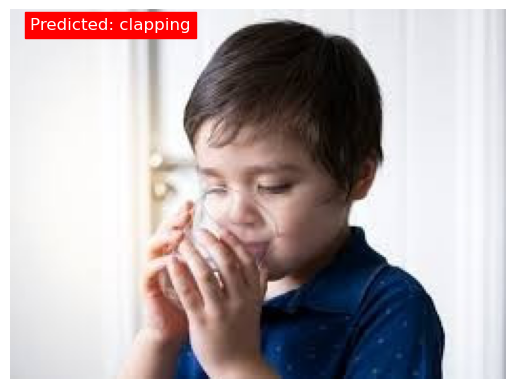

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Display the image with the predicted class name
image = np.array(image)
plt.imshow(image)
plt.axis('off')
plt.text(10, 10, f'Predicted: {predicted_class_name}', fontsize=12, color='white', backgroundcolor='red')
plt.show()